In [38]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from sklearn.model_selection import train_test_split

# Load dataset CIFAR-10
(x_train_full, y_train_full), (x_test, y_test) = cifar10.load_data()

# Normalize jadi rentang 0-1
x_train_full = x_train_full.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

# 40k train, 10k validation (4 banding 1)
x_train, x_val, y_train, y_val = train_test_split(
    x_train_full, y_train_full, test_size=0.2, random_state=42
)

print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")
print(f"x_val shape: {x_val.shape}, y_val shape: {y_val.shape}")
print(f"x_test shape: {x_test.shape}, y_test shape: {y_test.shape}")

x_train shape: (40000, 32, 32, 3), y_train shape: (40000, 1)
x_val shape: (10000, 32, 32, 3), y_val shape: (10000, 1)
x_test shape: (10000, 32, 32, 3), y_test shape: (10000, 1)


In [40]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam

def base_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
        MaxPooling2D((2, 2)),

        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),

        Flatten(),
        Dense(64, activation='relu'),
        # 10 kelas
        Dense(10, activation='softmax')
    ])
    
    model.compile(
        optimizer=Adam(),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [41]:
model = base_model()

history = model.fit(
    x_train, y_train,
    epochs=10,
    validation_data=(x_val, y_val)
)

# Simpan bobot ke file, untuk digunakan di forward prop dari scratch
model.save_weights("base_cnn.weights.h5")

c:\Users\Hp\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.3529 - loss: 1.7553 - val_accuracy: 0.5796 - val_loss: 1.2173
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.5822 - loss: 1.1838 - val_accuracy: 0.6238 - val_loss: 1.0766
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.6464 - loss: 1.0123 - val_accuracy: 0.6483 - val_loss: 1.0140
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.6744 - loss: 0.9302 - val_accuracy: 0.6571 - val_loss: 0.9728
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.7032 - loss: 0.8498 - val_accuracy: 0.6547 - val_loss: 0.9978
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.7231 - loss: 0.7957 - val_accuracy: 0.6820 - val_loss: 0.9367
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.7431 - loss: 0.7416 - val_accuracy: 0.6840 - val_loss: 0.9337
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.7618 - loss: 0.6867 -

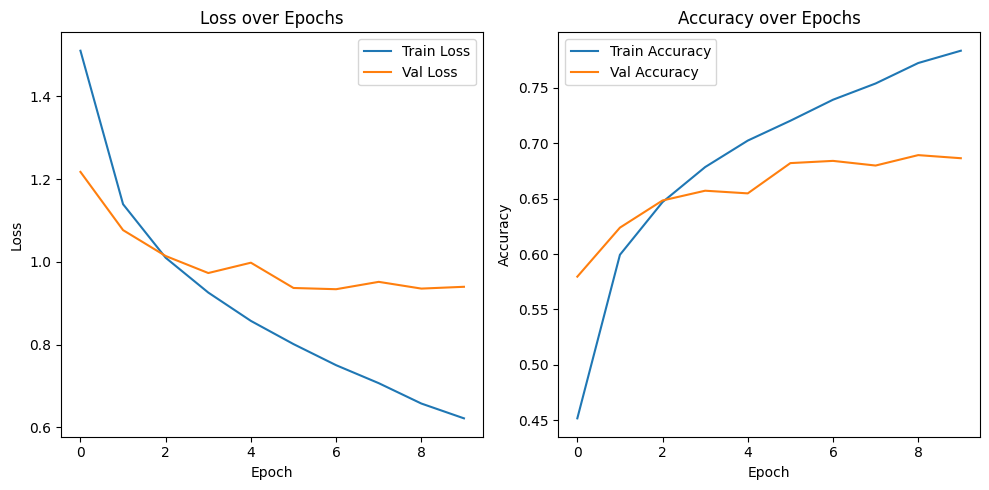

In [42]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    plt.figure(figsize=(10, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)

In [43]:
from sklearn.metrics import f1_score

# Predict kelasnya
y_pred_probs = model.predict(x_test)
y_pred = y_pred_probs.argmax(axis=1)

# Flatten label
y_test_flat = y_test.flatten()

# Hitung f1-score
f1 = f1_score(y_test_flat, y_pred, average='macro')
print(f"Macro F1-score on test set: {f1:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Macro F1-score on test set: 0.6812


In [44]:
def create_model_variant(num_conv_layers):
    model = Sequential()
    input_shape = (32, 32, 3)

    filters = [32, 64, 128][:num_conv_layers]
    
    for i, f in enumerate(filters):
        if i == 0:
            model.add(Conv2D(f, (3, 3), activation='relu', input_shape=input_shape))
        else:
            model.add(Conv2D(f, (3, 3), activation='relu'))
        model.add(MaxPooling2D((2, 2)))

    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(10, activation='softmax'))

    model.compile(
        optimizer=Adam(),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [45]:
from sklearn.metrics import f1_score

def train_and_evaluate_variants():
    histories = {}
    f1_scores = {}

    for layers in [1, 2, 3]:
        print(f"\nTraining model with {layers} Conv2D layers...")
        model = create_model_variant(layers)
        history = model.fit(
            x_train, y_train,
            epochs=10,
            validation_data=(x_val, y_val),
            verbose=0
        )

        # Simpan histori training layer
        histories[layers] = history

        # Hitung f1-score untuk test set
        y_pred = model.predict(x_test).argmax(axis=1)
        f1 = f1_score(y_test.flatten(), y_pred, average='macro')
        f1_scores[layers] = f1

        print(f"Macro F1-score for {layers} Conv2D layers: {f1:.4f}")
    
    return histories, f1_scores

histories_conv, f1_conv = train_and_evaluate_variants()


Training model with 1 Conv2D layers...


c:\Users\Hp\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Macro F1-score for 1 Conv2D layers: 0.6241

Training model with 2 Conv2D layers...


c:\Users\Hp\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Macro F1-score for 2 Conv2D layers: 0.6949

Training model with 3 Conv2D layers...


c:\Users\Hp\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Macro F1-score for 3 Conv2D layers: 0.7022


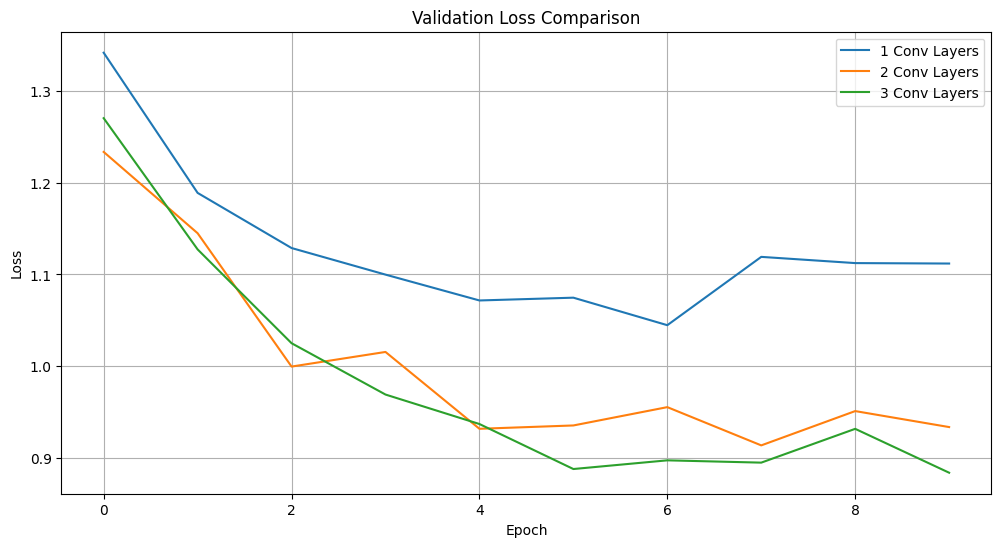

In [46]:
def plot_all_losses(histories):
    plt.figure(figsize=(12, 6))

    for num_layers, history in histories.items():
        plt.plot(history.history['val_loss'], label=f'{num_layers} Conv Layers')

    plt.title('Validation Loss Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_all_losses(histories_conv)

In [17]:
def create_model_with_filters(filter_list):
    model = Sequential()
    input_shape = (32, 32, 3)

    for i, f in enumerate(filter_list):
        if i == 0:
            model.add(Conv2D(f, (3, 3), activation='relu', input_shape=input_shape))
        else:
            model.add(Conv2D(f, (3, 3), activation='relu'))
        model.add(MaxPooling2D((2, 2)))

    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(10, activation='softmax'))

    model.compile(
        optimizer=Adam(),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [47]:
def train_and_evaluate_filters():
    filter_configs = {
        '16-32': [16, 32],
        '32-64': [32, 64],
        '64-128': [64, 128],
    }

    histories = {}
    f1_scores = {}

    for name, filters in filter_configs.items():
        print(f"\nTraining model with filters: {filters}")
        model = create_model_with_filters(filters)
        history = model.fit(
            x_train, y_train,
            epochs=10,
            validation_data=(x_val, y_val),
            verbose=0
        )

        histories[name] = history
        y_pred = model.predict(x_test).argmax(axis=1)
        f1 = f1_score(y_test.flatten(), y_pred, average='macro')
        f1_scores[name] = f1

        print(f"Macro F1-score for filters {name}: {f1:.4f}")

    return histories, f1_scores

histories_filters, f1_filters = train_and_evaluate_filters()


Training model with filters: [16, 32]


c:\Users\Hp\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Macro F1-score for filters 16-32: 0.6611

Training model with filters: [32, 64]


c:\Users\Hp\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Macro F1-score for filters 32-64: 0.6547

Training model with filters: [64, 128]


c:\Users\Hp\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Macro F1-score for filters 64-128: 0.6996


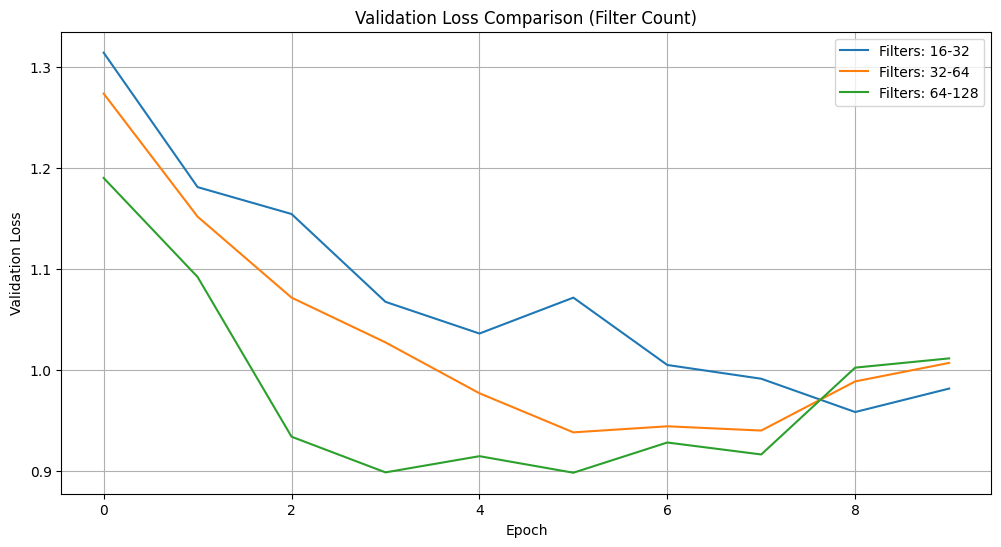

In [48]:
def plot_filter_losses(histories):
    plt.figure(figsize=(12, 6))

    for name, history in histories.items():
        plt.plot(history.history['val_loss'], label=f'Filters: {name}')

    plt.title('Validation Loss Comparison (Filter Count)')
    plt.xlabel('Epoch')
    plt.ylabel('Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_filter_losses(histories_filters)

In [49]:
def create_model_with_kernel_size(kernel_size):
    model = Sequential()
    input_shape = (32, 32, 3)
    filters = [32, 64]

    for i, f in enumerate(filters):
        if i == 0:
            model.add(Conv2D(f, kernel_size, activation='relu', input_shape=input_shape))
        else:
            model.add(Conv2D(f, kernel_size, activation='relu'))
        model.add(MaxPooling2D((2, 2)))

    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(10, activation='softmax'))

    model.compile(
        optimizer=Adam(),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [50]:
def train_and_evaluate_kernel_sizes():
    kernel_variants = {
        '3x3': (3, 3),
        '5x5': (5, 5),
        '7x7': (7, 7),
    }

    histories = {}
    f1_scores = {}

    for name, kernel in kernel_variants.items():
        print(f"\nTraining model with kernel size: {name}")
        model = create_model_with_kernel_size(kernel)
        history = model.fit(
            x_train, y_train,
            epochs=10,
            validation_data=(x_val, y_val),
            verbose=0
        )

        histories[name] = history
        y_pred = model.predict(x_test).argmax(axis=1)
        f1 = f1_score(y_test.flatten(), y_pred, average='macro')
        f1_scores[name] = f1

        print(f"Macro F1-score for kernel {name}: {f1:.4f}")

    return histories, f1_scores

histories_kernels, f1_kernels = train_and_evaluate_kernel_sizes()


Training model with kernel size: 3x3


c:\Users\Hp\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Macro F1-score for kernel 3x3: 0.6822

Training model with kernel size: 5x5


c:\Users\Hp\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Macro F1-score for kernel 5x5: 0.6691

Training model with kernel size: 7x7


c:\Users\Hp\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Macro F1-score for kernel 7x7: 0.6017


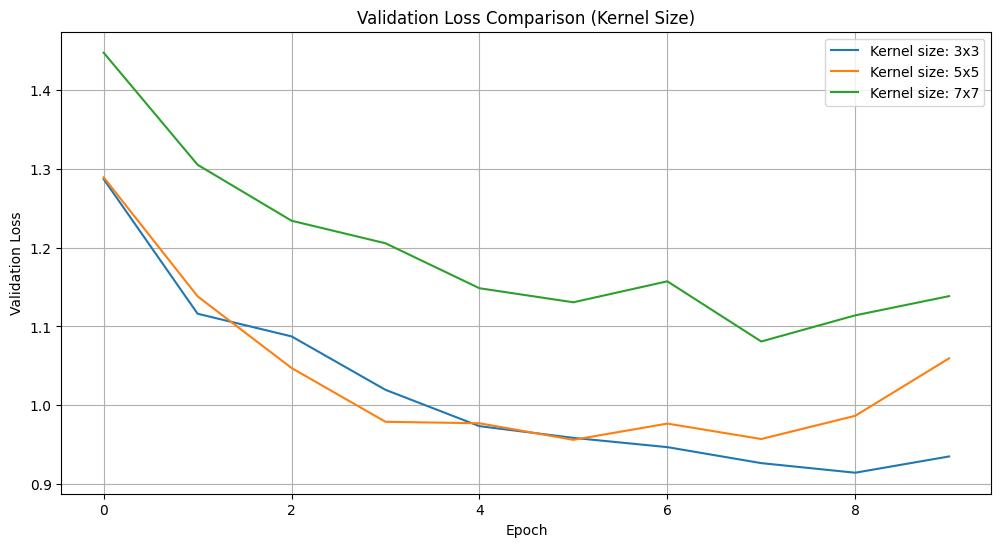

In [51]:
def plot_kernel_losses(histories):
    plt.figure(figsize=(12, 6))

    for name, history in histories.items():
        plt.plot(history.history['val_loss'], label=f'Kernel size: {name}')

    plt.title('Validation Loss Comparison (Kernel Size)')
    plt.xlabel('Epoch')
    plt.ylabel('Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_kernel_losses(histories_kernels)

In [52]:
from tensorflow.keras.layers import MaxPooling2D, AveragePooling2D

def create_model_with_pooling(pooling_type='max'):
    model = Sequential()
    input_shape = (32, 32, 3)
    filters = [32, 64]
    PoolingLayer = MaxPooling2D if pooling_type == 'max' else AveragePooling2D

    for i, f in enumerate(filters):
        if i == 0:
            model.add(Conv2D(f, (3, 3), activation='relu', input_shape=input_shape))
        else:
            model.add(Conv2D(f, (3, 3), activation='relu'))
        model.add(PoolingLayer((2, 2)))

    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(10, activation='softmax'))

    model.compile(
        optimizer=Adam(),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [53]:
def train_and_evaluate_pooling():
    pooling_variants = ['max', 'average']
    histories = {}
    f1_scores = {}

    for pool_type in pooling_variants:
        print(f"\nTraining model with {pool_type} pooling")
        model = create_model_with_pooling(pool_type)
        history = model.fit(
            x_train, y_train,
            epochs=10,
            validation_data=(x_val, y_val),
            verbose=0
        )

        histories[pool_type] = history
        y_pred = model.predict(x_test).argmax(axis=1)
        f1 = f1_score(y_test.flatten(), y_pred, average='macro')
        f1_scores[pool_type] = f1

        print(f"Macro F1-score with {pool_type} pooling: {f1:.4f}")

    return histories, f1_scores

histories_pooling, f1_pooling = train_and_evaluate_pooling()


Training model with max pooling


c:\Users\Hp\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Macro F1-score with max pooling: 0.6908

Training model with average pooling


c:\Users\Hp\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Macro F1-score with average pooling: 0.6679


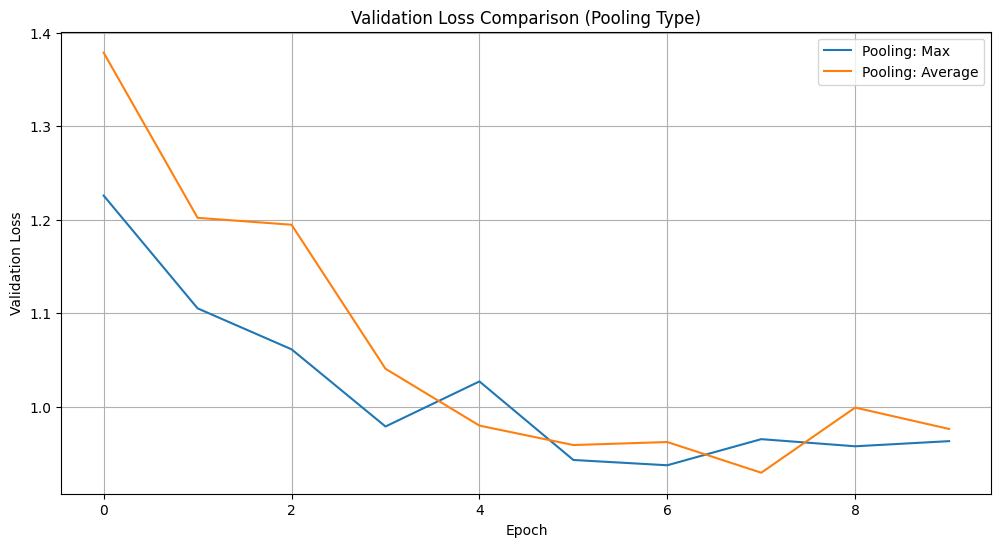

In [26]:
def plot_pooling_losses(histories):
    plt.figure(figsize=(12, 6))

    for pool_type, history in histories.items():
        plt.plot(history.history['val_loss'], label=f'Pooling: {pool_type.capitalize()}')

    plt.title('Validation Loss Comparison (Pooling Type)')
    plt.xlabel('Epoch')
    plt.ylabel('Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_pooling_losses(histories_pooling)

In [ ]:
import numpy as np

class Conv2DLayer:
    def __init__(self, weights, biases, stride=1, padding=0):
        self.weights = weights
        self.biases = biases
        self.stride = stride
        self.padding = padding

    def forward(self, x):
        batch_size, H_in, W_in, C_in = x.shape
        F_h, F_w, C_in_w, Num_filters = self.weights.shape

        assert C_in == C_in_w, "Input channel size mismatch"

        H_out = (H_in - F_h + 2 * self.padding) // self.stride + 1
        W_out = (W_in - F_w + 2 * self.padding) // self.stride + 1

        if self.padding > 0:
            x_padded = np.pad(x, ((0,0), (self.padding,self.padding), (self.padding,self.padding), (0,0)), mode='constant')
        else:
            x_padded = x

        out = np.zeros((batch_size, H_out, W_out, Num_filters))

        for b in range(batch_size):
            for h in range(H_out):
                for w in range(W_out):
                    for f in range(Num_filters):
                        vert_start = h * self.stride
                        vert_end = vert_start + F_h
                        horiz_start = w * self.stride
                        horiz_end = horiz_start + F_w

                        x_slice = x_padded[b, vert_start:vert_end, horiz_start:horiz_end, :]
                        out[b, h, w, f] = np.sum(x_slice * self.weights[:, :, :, f]) + self.biases[f]

        return out

In [ ]:
conv_layer = model.layers[0]
weights, biases = conv_layer.get_weights()

conv_scratch = Conv2DLayer(weights=weights, biases=biases, stride=1, padding=0)

In [ ]:
x_sample = x_test[:2]
keras_out = conv_layer(x_sample).numpy()
scratch_out = conv_scratch.forward(x_sample)

print("Difference:", np.abs(keras_out - scratch_out).mean())

Difference: 0.1381666269701903


In [30]:
class ReLULayer:
    def forward(self, x):
        return np.maximum(0, x)

In [ ]:
class PoolingLayer:
    def __init__(self, pool_size=2, stride=2, mode='max'):
        self.pool_size = pool_size
        self.stride = stride
        self.mode = mode

    def forward(self, x):
        batch_size, H_in, W_in, C = x.shape
        pool_h, pool_w = self.pool_size, self.pool_size

        H_out = (H_in - pool_h) // self.stride + 1
        W_out = (W_in - pool_w) // self.stride + 1

        out = np.zeros((batch_size, H_out, W_out, C))

        for b in range(batch_size):
            for h in range(H_out):
                for w in range(W_out):
                    for c in range(C):
                        vert_start = h * self.stride
                        vert_end = vert_start + pool_h
                        horiz_start = w * self.stride
                        horiz_end = horiz_start + pool_w

                        x_slice = x[b, vert_start:vert_end, horiz_start:horiz_end, c]

                        if self.mode == 'max':
                            out[b, h, w, c] = np.max(x_slice)
                        else:
                            out[b, h, w, c] = np.mean(x_slice)

        return out

In [ ]:
class FlattenLayer:
    def forward(self, x):
        batch_size = x.shape[0]
        return x.reshape(batch_size, -1)

In [ ]:
class DenseLayer:
    def __init__(self, weights, biases):
        self.weights = weights
        self.biases = biases

    def forward(self, x):
        return np.dot(x, self.weights) + self.biases

In [ ]:
class SoftmaxLayer:
    def forward(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

In [ ]:
import numpy as np
from sklearn.metrics import f1_score

# Load bobot dari file
conv1_w, conv1_b = model.layers[0].get_weights()
conv2_w, conv2_b = model.layers[2].get_weights()
dense1_w, dense1_b = model.layers[5].get_weights()
dense2_w, dense2_b = model.layers[6].get_weights()

# Inisialisasi layer dengan bobot hasil load
conv1 = Conv2DLayer(conv1_w, conv1_b, stride=1, padding=0)
conv2 = Conv2DLayer(conv2_w, conv2_b, stride=1, padding=0)
relu = ReLULayer()
pool = PoolingLayer(pool_size=2, stride=2, mode='max')
flatten = FlattenLayer()
dense1 = DenseLayer(dense1_w, dense1_b)
dense2 = DenseLayer(dense2_w, dense2_b)
softmax = SoftmaxLayer()

# Forward propagation setiap layer
def forward_pass_scratch(x):
    out = conv1.forward(x)
    out = relu.forward(out)
    out = pool.forward(out)

    out = conv2.forward(out)
    out = relu.forward(out)
    out = pool.forward(out)

    out = flatten.forward(out)
    out = dense1.forward(out)
    out = relu.forward(out)
    out = dense2.forward(out)
    out = softmax.forward(out)
    return out

# Test ke sampel kecil
x_sample = x_test[:10]
keras_output = model.predict(x_sample)
scratch_output = forward_pass_scratch(x_sample)

print("Mean difference between Keras and scratch outputs:", np.abs(keras_output - scratch_output).mean())

keras_preds = np.argmax(keras_output, axis=1)
scratch_preds = np.argmax(scratch_output, axis=1)

print("Macro F1-score Keras:", f1_score(y_test[:10], keras_preds, average='macro'))
print("Macro F1-score Scratch:", f1_score(y_test[:10], scratch_preds, average='macro'))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Mean difference between Keras and scratch outputs: 3.017530832268501e-08
Macro F1-score Keras: 0.5208333333333333
Macro F1-score Scratch: 0.5208333333333333
